## Problem 1: Design a model

I'm choosing to model an ideal gas, to see if the ideal gas law holds up ($ PV = Nk_BT $ )<br>

- At which scale do you choose to describe the microscopic components and what are those
components? Briefly describe other scales (larger and/or smaller) at which you could have
chosen to model the microscopic state and why your chosen scale is the most appropriate.

    + The model would descirbe the system on the molecule scale, simulating every molecule of an ideal gas, and tracking their position and momentum. It would also model the compartment that the gas is in. With this I can measure the Preasure (P) by the change in momentum of the particles hitting the walls of the container at every timestep, the Volume, or hypervolume (V) as a function of the lenght of the sides of the container, N is the number of particles, which is a parameter, kB is a constant, and Temperature (T) is a function of the average kinectic energy of the particles that is a funtion of their momentum. 

    <br> 
    
- What states can the microscopic components take on?

    + The states in this case are continous, and they are the different values of the position and momentum. In Statistical Mechanics we call phase space the space of all those states, and it is a function of the configuration space (position) and the momentum space (momentum). This is essential for calculating the entropy of the system.

    <br> 
    
- What are the relationships between the components?

    + The molecules float arround and bounce into each other with perfectly elastic colisions 

    <br> 
    

- How do the states of the components change over time? Some of these changes may
depend on interactions between the components while other changes may not.

    + The major change in the states is that the positions of the particles should spread out over time, no matter where they start, and the overall entropy should increase. 

    <br>

We have actually already done a model for this in the statistical mechanics class, and the addapted version of it is in the next cell
    

(1001, 500, 2)
here is first frame, when ready may need to click 'fetch additional output' to watch movie:


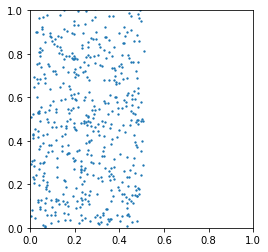

MovieWriter ffmpeg unavailable; using Pillow instead.


./tmp2ap4tw26.gif


In [2]:
#addapted for the first assignment for NS162 class

import numpy as np
from numpy.random import random
from numpy import sqrt, sin,cos, pi, array, dot
import matplotlib.pyplot as plt

import time

from matplotlib import animation, rc
from IPython.display import HTML
import tempfile; tempfile.tempdir='./'


# modified from https://github.com/vpython/visual/blob/master/examples/gas.py
# converted to 2d, switched to pure numpy functions, visualization using matplotlib instead of vpython

# A model of an ideal gas with hard-sphere collisions
# Program uses Numeric Python arrays for high speed computations
k = 1.4E-23 # Boltzmann constant
Matom = 4E-3/6E23 # helium mass in kg

def simulate_gas(Natoms=1000, Nframes=500,  T=300, L=1, Ratom=0.003,dt=1E-5, start_half=False, start_uneven_energy=False):
# A model of an ideal gas with hard-sphere collisions
# Nframes is number of timesteps of dt to simulate
# T is temperature in K, L is box size in m, Ratom is atom radius in m, dt is timestep in seconds
# Returns poslist_frames -- list of postions of all atoms at each frame
#         plist_frames -- list of corresponding momenta of all atoms at each frame
#         wall_dp_frames -- sum of absolute value of momenta transfer to all 4 walls during each frame
    poslist = []
    plist = []
    mlist = []
    rlist = []

    # initialize the positions of the atoms
    for i in range(Natoms):
        Lmin = 1.1*Ratom
        Lmax = L-Lmin
        if (start_half): # start all of the atoms on the LHS of the box
          x = Lmin+0.5*(Lmax-Lmin)*random()
          y = Lmin+(Lmax-Lmin)*random()
        else:
          x = Lmin+(Lmax-Lmin)*random()
          y = Lmin+(Lmax-Lmin)*random()
    #   z = Lmin+(Lmax-Lmin)*random()
        r = Ratom
        mass = Matom*r**3/Ratom**3 # only would matter if we had different atom sizes
        pavg = sqrt(2.*mass*1.*k*T) # average kinetic energy p**2/(2mass) = (2/2)kT (2d gas)
        phi = 2*pi*random()
        if (start_uneven_energy and i>Natoms/2):
          px = 0
          py = 0
        else:
          px = pavg*cos(phi)
          py = pavg*sin(phi)
    #    pz = pavg*cos(theta)
        poslist.append((x,y))
        plist.append((px,py))
        mlist.append(mass)
        rlist.append(r)

    pos = array(poslist)
    p = array(plist)
    m = array(mlist)
    m.shape = (Natoms,1) # Numeric Python: (1 by Natoms) vs. (Natoms by 1)
    radius = array(rlist)

    t = 0.0
    Nsteps = 0
    pos = pos+(p/m)*(dt/2.) # initial half-step

    poslist_frames = [pos];
    plist_frames = [p];
    wall_dp_frames = [0];

    while (Nsteps < Nframes):
        # Update all positions
        pos = pos+(p/m)*dt

        r = pos-pos[:,np.newaxis] # all pairs of atom-to-atom vectors
        rmag = sqrt(np.sum(r*r,-1)) # atom-to-atom scalar distances
        hit = np.less_equal(rmag,radius+radius[:,np.newaxis])-np.identity(Natoms)
        hitlist = np.sort(np.nonzero(hit.flatten())).tolist()[0]# i,j encoded as i*Natoms+j    
        # If any collisions took place:

        hitlist_nodups = hitlist
        for ij in hitlist:
            i, j = np.divmod(ij,Natoms) # decode atom pair
            hitlist_nodups.remove(j*Natoms+i) # remove symmetric j,i pair from list

        for ij in hitlist_nodups:
            i, j = np.divmod(ij,Natoms) # decode atom pair
            #print(i,j, np.sqrt(np.sum((pos[i]-pos[j])**2)))
            ptot = p[i]+p[j]
            mi = m[i,0]
            mj = m[j,0]
            vi = p[i]/mi
            vj = p[j]/mj
            ri = radius[i]
            rj = radius[j]
            a = np.linalg.norm(vj-vi)**2
            if a == 0: continue # exactly same velocities
            b = 2*dot(pos[i]-pos[j],vj-vi)
            c = np.linalg.norm(pos[i]-pos[j])**2-(ri+rj)**2
            d = b**2-4.*a*c
            if d < 0: continue # something wrong; ignore this rare case
            deltat = (-b+sqrt(d))/(2.*a) # t-deltat is when they made contact
            pos[i] = pos[i]-(p[i]/mi)*deltat # back up to contact configuration
            pos[j] = pos[j]-(p[j]/mj)*deltat
            mtot = mi+mj
            pcmi = p[i]-ptot*mi/mtot # transform momenta to cm frame
            pcmj = p[j]-ptot*mj/mtot
            rrel = (pos[j]-pos[i])/np.linalg.norm(pos[j]-pos[i])
            #print(pcmi,pcmj, rrel)
            #print(dot(pcmi,rrel))
            pcmi = pcmi-2*dot(pcmi,rrel)*rrel # bounce in cm frame
            pcmj = pcmj-2*dot(pcmj,rrel)*rrel
            #print(pcmi,pcmj)
            #print(p[i],p[j],pos[i],pos[j])
            p[i] = pcmi+ptot*mi/mtot # transform momenta back to lab frame
            p[j] = pcmj+ptot*mj/mtot
            pos[i] = pos[i]+(p[i]/mi)*deltat # move forward deltat in time
            pos[j] = pos[j]+(p[j]/mj)*deltat
            #print(p[i],p[j],pos[i],pos[j])


        # Bounce off walls
        wall_dp = 0

        outside = np.less_equal(pos,Ratom) # walls closest to origin
        p1 = p*outside
        pnew = p-p1+abs(p1)
        wall_dp += np.sum(abs(p - pnew)) #calculate contributions to pressure        
        p = pnew # force p component inward

        outside = np.greater_equal(pos,L-Ratom) # walls farther from origin
        p1 = p*outside
        pnew = p-p1-abs(p1) # force p component inward
        wall_dp += np.sum(abs(p - pnew)) #calculate contributions to pressure        
        p = pnew # force p component inward

        poslist_frames.append(pos) # save the positions for this frame
        wall_dp_frames.append(wall_dp) # save the momentum transfer to the wall
        plist_frames.append(p)

        Nsteps = Nsteps+1
        t = t+dt

    return poslist_frames, plist_frames, wall_dp_frames

# matplotlib jupyter animations based on http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

def animate_gas(poslist_frames,Ratom_anim = 0.003, L_anim = 1):
    # Generate animation
    width = 4 # width of plot in inches

    # set-up figure and ax
    fig, ax = plt.subplots(figsize=(width,width))
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    simgraph = ax.scatter([], [])

    # convert atom size to figure units
    t = ax.transAxes.transform([(0,0), (Ratom_anim,Ratom_anim)])
    Ratom_pts = (t[1,1]-t[0,0]) * 72/fig.dpi
    s_circ = (Ratom_pts * 2)**2

    def init_model():
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        simgraph = ax.scatter([], [])
        return (simgraph,)

    def animate_model(i):
        ax.clear()
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        simgraph = ax.scatter(poslist_frames[i][:,0], poslist_frames[i][:,1], s=s_circ)
        return (simgraph,)

    print("here is first frame, when ready may need to click 'fetch additional output' to watch movie:")
    animate_model(1)
    plt.show()

    # run to generate the html5 video of the positions
    # (takes about 30s for 100 frames)
    # click 'Fetch additional output to see'
    anim = animation.FuncAnimation(fig, animate_model, init_func=init_model,
                                  frames=len(poslist_frames), interval=40)
    
    
    fname = tempfile.mktemp('.gif')
    print(fname)
    anim.save(fname)
    time.sleep(0.1) # make sure file is saved
    return display(HTML("""
                <image style="width:200" src="{}" >
                """.format(fname)))


# set simulation parameters
Natoms = 500
Nframes = 1000
dt = 1E-5 # s
T=300 # Kelvin
Ratom = 0.003 # meters -- grossly exagerated
L = 1 # meters


poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L, dt=dt, T=T, start_half=True)
animate_gas(poslist_frames[:100], Ratom_anim=Ratom, L_anim=L)

## Problem 2: Is the random module random?


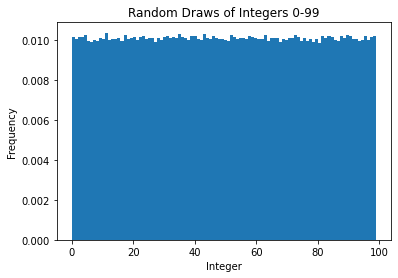

In [29]:
import numpy as np
import matplotlib.pyplot as plt

numbers = np.random.randint(100, size=1000000)

plt.hist(numbers, density=True, bins=100)
plt.title("Random Draws of Integers 0-99")
plt.ylabel("Frequency")
plt.xlabel("Integer")
plt.show()

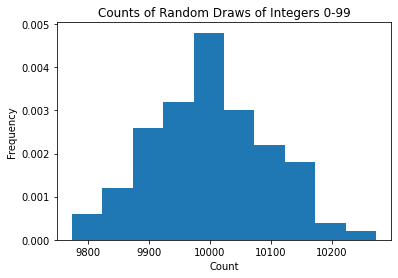

In [30]:
_, c = np.unique(numbers, return_counts = True)
plt.hist(c, density= True)
plt.title("Counts of Random Draws of Integers 0-99")
plt.ylabel("Frequency")
plt.xlabel("Count")
plt.show()

Given that a good random sampler should draw the values from an uniform distribution, I would expect each of the 100 numbers to appear about 1% of of the times, which was what was shown in the first histogram.<br>
If we make a histogram of how many times each number was picked, we get something the looks normaly distributed, which agrees to the CLT, since we are sampling 1000000 from another distribution. 

## Problem 3: Forest fire mean-field approximation

Rules: 

1. p(fire -> empty) = 1
2. p(tree -> fire) = (1 -g), if at least 1 neighbor is f. 
3. p(tree -> fire) = (1 - g)f
4. p(empty -> tree) = p

1. $∆\rho_e = \rho_f − p\rho_e $
 
    - The space will be empty if it was already empty and a tree did not grow there ($ p\rho_e $), or if the place was on fire before ($ \rho_f $). With this, the proportion of the empty spaces changes based on the difference of the proportion of those 2 events, so, $∆\rho_e = \rho_f − p\rho_e $.  
    
    <br>

2. $ ∆\rho_t = p\rho_e - \rho_t(1-g)(f + (1-f)(1 - (1-\rho_f)^{2d})) $

    - For this one we need to think about the trees that spawn in empty spaces, minus the trees that get burned. 
    - Trees spawning in empty places is given by ($ p\rho_e $), which is the proportion of empty places times the probability of a tree spawning.
    - The trees catching on fire depends on 2 requirements:
        + It has to be a tree ($ \rho_t $)
        + It has to not be imune ($ 1-g $)
    - Once these requirements are met, there are 2 ways it can catch on fire:
        + it is struck by a lightning ($ f $)
        + or it not struck by a lightning and it has a neighbour on fire ($ (1-f) p_{nf} $)
            - $ p_{nf} $ is the probability that at least 1 neighbour is on fire which is given by $ 1 - (1-p_f)^2d $. This is beacuase the probabilty of 1 individual not being on fire is $ (1-p_f) $ , which has 2d neighbours in d dimentions.

    So, putting everything together, we have $ ∆\rho_t = p\rho_e - \rho_t(1-g)(f + (1-f)(1 - (1-\rho_f)^{2d})) $

    <br>

3. $ ∆ρ_f = -\rho_f + \rho_t(1-g)(f + (1-f)(1 - (1-\rho_f)^{2d})) $

    - we already did the prob of a tree catching on fire above ($ \rho_t(1-g)(f + (1-f)(1 - (1-\rho_f)^{2d})) $), so given that every fire dies in 1 turn, we just subtract this proportion by $ p_f $. So, $ ∆ρ_f =  \rho_t(1-g)(f + (1-f)(1 - (1-\rho_f)^{2d})) -\rho_f = ∆ρ_f = -\rho_f + \rho_t(1-g)(f + (1-f)(1 - (1-\rho_f)^{2d}))$


## Problem 4: Wireworld


In [70]:
from IPython.display import HTML
import tempfile; tempfile.tempdir='./'

import time as tm
from matplotlib import colors

from celluloid import Camera


MovieWriter imagemagick unavailable; using Pillow instead.


./tmpc8ca9jlw.gif


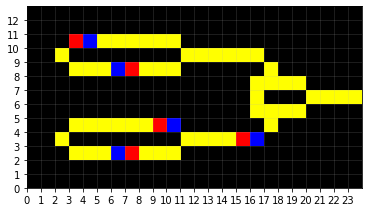

In [71]:
init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,3,3,2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,0,0,0,0,0,0,0,0,2,1,3,3,3,3,0,0,0,0,0,0,0],
                      [0,0,0,3,3,3,3,3,3,3,1,0,0,0,0,0,0,3,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,3,3,3],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,0,0,0,0],
                      [0,0,0,3,3,2,1,3,3,3,3,0,0,0,0,0,0,2,0,0,0,0,0,0],
                      [0,0,3,0,0,0,0,0,0,0,0,2,1,3,3,3,3,0,0,0,0,0,0,0],
                      [0,0,0,3,1,2,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

background, head, tail, wire = range(4)

def init():
    global config, nextConfig

    config = init_conf

    nextConfig = np.zeros([height, width])

def neighborhoodHasHead(config, x, y):
    MOORE_OFFSETS = [(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)]

    n = 0
    for neighbor in MOORE_OFFSETS:
        dy, dx = neighbor
        try:
            if y + dy >= 0 and x + dx >= 0 and config[y+dy][x+dx]==head:
                n += 1
        except IndexError:
            continue

    return (n == 1 or n == 2)  

def step():
    global config, nextConfig

    for y in range(height):
        for x in range(width):
            state = config[y, x]

            if state == head:
                state = tail

            elif state == tail:
                state = wire

            elif state == wire:
                if neighborhoodHasHead(config, x, y):
                    state = head

            nextConfig[y, x] = state

    config, nextConfig = nextConfig, config


def animate(n):
    fig = plt.figure()
    camera = Camera(fig)

    plt.xticks(range(0,init_conf.shape[1]))
    plt.yticks(range(0,init_conf.shape[0]))
    plt.grid(alpha = 0.2)
    cm = colors.ListedColormap(['black','b','red','yellow'])

    init()
    for _ in range(n):
        step()
        plt.xticks(range(0,init_conf.shape[1]))
        plt.yticks(range(0,init_conf.shape[0]))
        plt.grid(alpha = 0.2)
        plt.imshow(config, cmap = cm, extent = [0, config.shape[1], 0, config.shape[0]], animated = True)
        camera.snap()

    anim = camera.animate()

    fname = tempfile.mktemp('.gif')
    print(fname)
    anim.save(fname, writer = 'imagemagick')
    tm.sleep(0.1) # make sure file is saved
    display(HTML("""
            <image style="width:200" src="{}" >
                """.format(fname)))

animate(100)


For this 4 bit adder, I decided to break it down into substeps. First I'm doing the or, xor, and and gates, and testing them for all inputs

MovieWriter imagemagick unavailable; using Pillow instead.


./tmp0ysyqwvc.gif


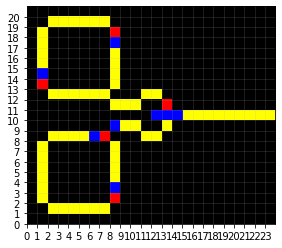

In [72]:
#or gate
init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,1,2,3,3,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,0,0,0,0,0,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3], 
                      [0,0,0,0,0,0,0,0,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,1,2,3,3,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(40)


MovieWriter imagemagick unavailable; using Pillow instead.


./tmpp98yl5jl.gif


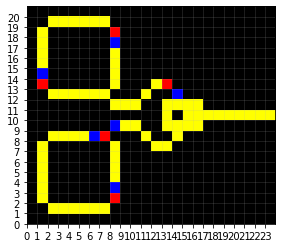

In [73]:
#xor gate
init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,1,2,3,3,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,0,0,0,0,0,3,3,3,0,0,3,3,3,3,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,3,3,3,3,3,3,3,3], 
                      [0,0,0,0,0,0,0,0,3,3,3,0,0,3,3,3,3,0,0,0,0,0,0,0],
                      [0,0,3,3,1,2,3,3,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(40)


MovieWriter imagemagick unavailable; using Pillow instead.


./tmpjzn89rr9.gif


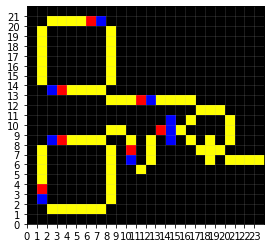

In [75]:
#and gate
init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,3,0,0,0], 
                      [0,0,0,0,0,0,0,0,3,3,0,0,0,3,3,3,0,0,0,0,3,0,0,0],
                      [0,0,3,3,1,2,3,3,0,0,3,0,3,0,3,0,3,0,3,0,3,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,3,0,3,0,0,0,0,3,3,3,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,3,0,3,0,0,0,0,0,3,0,3,3,3,3],
                      [0,2,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(50)


Then, I made a half-adder, which is a combination of an XOR and an AND gate. This design was the hardest one to do, because it is very hard to deal with the crossing wires. This took a lot time and a lot of trial and error to come up with this design, but now it works, so I tested it with different outcomes. <br>
In the outcome, S is the sum and C is the complement

MovieWriter imagemagick unavailable; using Pillow instead.


./tmpnzhncvc5.gif


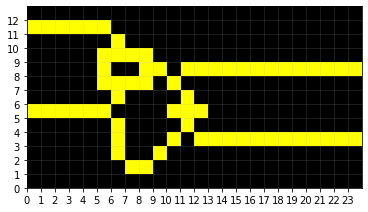

In [76]:
#half-adder 1 + 1 = (S = 0 ; C = 1)

init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [2,1,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(40)

MovieWriter imagemagick unavailable; using Pillow instead.


./tmphqv23zgj.gif


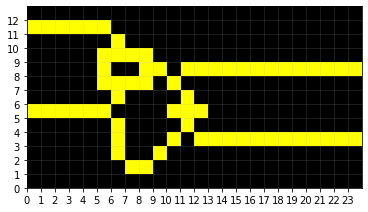

In [77]:
#half-adder 1 + 0 = (S = 1 ; C = 0)

init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(40)

MovieWriter imagemagick unavailable; using Pillow instead.


./tmpfneeob59.gif


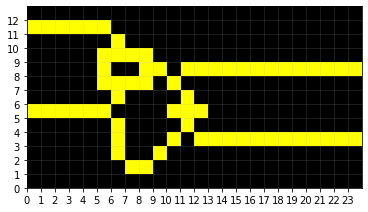

In [78]:
#half-adder 0 + 1 = (S = 1 ; C = 0)

init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [2,1,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(40)

With the half-adder done, I used 2 half-adders connected to an OR gate to simulate a full adder. In phisical circuits this is not the most cost effective way of doing this, but it simplifies the problem a lot

MovieWriter imagemagick unavailable; using Pillow instead.


./tmplzuz8nwv.gif


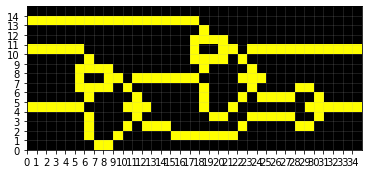

In [88]:
#full adder
init_conf = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [2,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3],
                      [0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0,0,0,0],
                      [3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3,3,3,3],
                      [0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0],
                      [0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

height = len(init_conf)
width = len(init_conf[0])

animate(50)

With both the half adder and the full adder we can start adding numbers. It is just a matter of connecting both. I made a 2 bit, 3 bit, and finally a 4 bit to exemplify it better.

MovieWriter imagemagick unavailable; using Pillow instead.


./tmpf6377gjp.gif


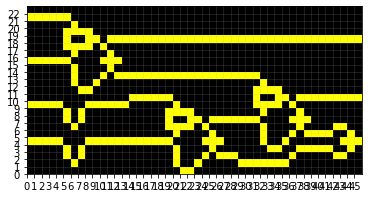

In [95]:
"""
2 digit binary adder

A0A1 + B0B1 = C0C1C2

input:      output:
B1          C2
A1          C1
B0          C0
A0

eg:
11 + 01 = 100

input:      output:
1           0
1           0
0           1
1

"""

init_conf = np.array([
    
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
[0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3],
[3,3,3,3,3,0,0,0,3,3,3,3,3,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0],
[2,1,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],    
     
                      ])

height = len(init_conf)
width = len(init_conf[0])

animate(50)

MovieWriter imagemagick unavailable; using Pillow instead.


./tmpik5_wp16.gif


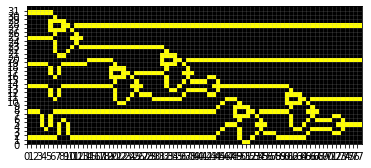

In [99]:
"""
3 digit binary adder

A0A1 + B0B1 = C0C1C2

input:      output:
B2          C3
A2          C2
B1          C1
A1          C0
B0          
A0

eg:
111 + 001 = 1000

input:      output:
1           0
1           0
0           0
1           1
0
1
"""

init_conf = np.array([
    
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
[0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
[3,3,3,3,3,0,0,0,3,3,3,3,3,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0],
[3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0],
[0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0,0,0,0],
[0,0,0,3,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0,0,0,0],
[0,0,0,3,0,3,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3,3,3,3],
[0,0,0,0,3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0,0,0,0],
[0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0],
[2,1,3,3,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]    
     
                      ])

height = len(init_conf)
width = len(init_conf[0])

animate(100)

MovieWriter imagemagick unavailable; using Pillow instead.


./tmpmsjq_7ke.gif


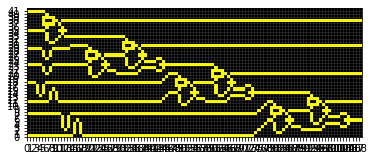

In [100]:
"""
4 digit binary adder

A0A1 + B0B1 = C0C1C2

input:      output:
B3
A3          C4
B2          C3
A2          C2
B1          C1
A1          C0
B0          
A0

eg:
1111 + 0001 = 1000

input:      output:
1           0
1           0
0           0
1           0
0           1
1
0
1
"""

init_conf = np.array([
    
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
[0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
[3,3,3,3,3,0,0,0,3,3,3,3,3,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,3,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,3,0,3,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[2,1,3,3,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,3,3,0,3,3,3,3,3,3,3,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0],
[3,3,3,3,3,3,3,3,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3,3,3,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,3,3,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,3,0,3,3,3,3,0,0,3,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,3,3,3,3,3,3],
[0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,3,3,3,3,3,0,0,3,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,3,0,3,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,3,0,0,0,0,0,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
[2,1,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  

                      ])

height = len(init_conf)
width = len(init_conf[0])

animate(130)